In [4]:
import numpy as np
import matplotlib.pyplot as plt
from metpy.calc import moist_lapse
from metpy.units import units
import climlab

# === Step 1: Define pressure levels ===
p = np.linspace(1000, 100, 20) * units.hPa

# === Step 2: Generate moist adiabatic reference profile ===
T_surf = 300 * units.K
T_profile = moist_lapse(p, T_surf).magnitude[::-1]
T_profile = np.clip(T_profile, 180, None)

# === Step 3: Set up Climlab column state ===
state = climlab.column_state(lev=p.magnitude, water_depth=1.0)

# Extract temperature and pressure
T = state.Tatm
p_levels = state.Tatm.domain.lev.points
nlev = len(p_levels)

print(p)
print(p_levels)

# Compute saturation specific humidity
q_profile = climlab.utils.thermo.qsat(T, p_levels)

# === Step 4: Set up base radiation model ===
rad_base = climlab.radiation.RRTMG(name='Rad_base',
                                   state=state,
                                   specific_humidity=q_profile,
                                   albedo=0.3)

[1000.0 952.6315789473684 905.2631578947369 857.8947368421052 810.5263157894736 763.1578947368421 715.7894736842105 668.421052631579 621.0526315789473 573.6842105263158 526.3157894736842 478.9473684210526 431.57894736842104 384.2105263157895 336.8421052631578 289.47368421052624 242.10526315789468 194.73684210526312 147.36842105263156 100.0] hectopascal
[ 100.          147.36842105  194.73684211  242.10526316  289.47368421
  336.84210526  384.21052632  431.57894737  478.94736842  526.31578947
  573.68421053  621.05263158  668.42105263  715.78947368  763.15789474
  810.52631579  857.89473684  905.26315789  952.63157895 1000.        ]


In [ ]:

rad_base.compute_diagnostics()
LW_ref = rad_base.diagnostics['TdotLW'].copy()
SW_ref = rad_base.diagnostics['TdotSW'].copy()

# === Step 5: Initialize kernel storage ===
kernel_LW = np.zeros((nlev, nlev))
kernel_SW = np.zeros((nlev, nlev))

# === Step 6: Loop over all vertical levels for perturbation ===
for k in range(nlev):
    delta_q = np.zeros_like(q_profile)
    delta_q[k] = 1e-5  # Dirac moisture perturbation

    # Fresh radiation model per perturbation
    rad_pert = climlab.radiation.RRTMG(name=f'Rad_pert_{k}',
                                       state=state,
                                       specific_humidity=q_profile + delta_q,
                                       albedo=0.3)
    rad_pert.compute_diagnostics()
    LW_pert = rad_pert.diagnostics['TdotLW'].copy()
    SW_pert = rad_pert.diagnostics['TdotSW'].copy()

    # Compute kernel column (response at all levels to impulse at level k)
    kernel_LW[:, k] = (LW_pert - LW_ref) / delta_q[k]
    kernel_SW[:, k] = (SW_pert - SW_ref) / delta_q[k]

# === Step 7: Plot total radiative response kernel ===
plt.figure(figsize=(7, 6))
cs=plt.contourf(p_levels, p_levels, (kernel_LW + kernel_SW)*1e-3, levels=21, cmap='RdBu_r')
plt.ylim([150,1000])
plt.xlim([150,1000])
#plt.contour(p_levels, p_levels, (kernel_LW + kernel_SW)*1e-3, levels=[0,0.001],color='k')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('Perturbation level [hPa]')
plt.ylabel('Response level [hPa]')
plt.title('Total Radiative Response Kernel [K/day per g/kg]')
plt.colorbar(cs,label='K/day per g/kg')
plt.tight_layout()
plt.show()


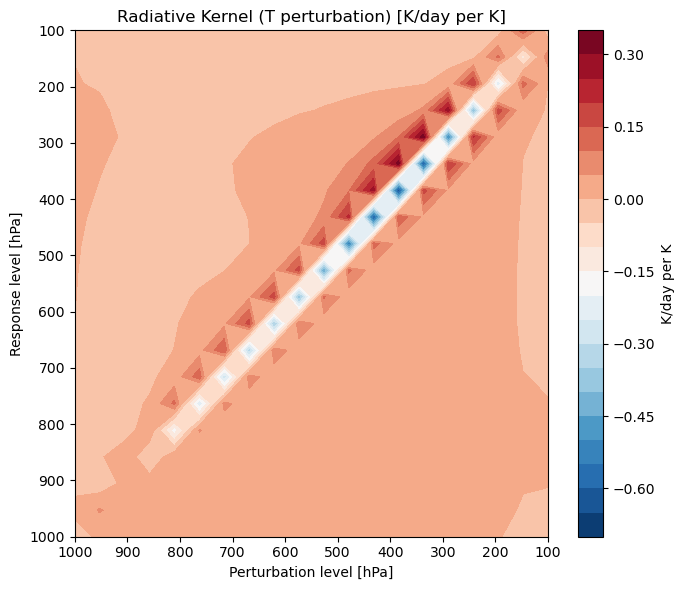

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from metpy.calc import moist_lapse
from metpy.units import units
import climlab

# === Step 1: Define pressure levels ===
p = np.linspace(1000, 100, 20) * units.hPa

# === Step 2: Generate moist adiabatic reference profile ===
T_surf = 300 * units.K
T_profile = moist_lapse(p[::-1], T_surf).magnitude[::-1]
T_profile = np.clip(T_profile, 180, None)

# === Step 3: Set up Climlab column state ===
levs = p.magnitude
state = climlab.column_state(lev=levs, water_depth=1.0)
state['Tatm'][:] = T_profile

# Compute saturation specific humidity
q_profile = climlab.utils.thermo.qsat(state.Tatm, levs)

# === Step 4: Set up base radiation model ===
rad_base = climlab.radiation.RRTMG(name='Rad_base',
                                   state=state,
                                   specific_humidity=q_profile,
                                   albedo=0.3)
rad_base.compute_diagnostics()
LW_ref = rad_base.diagnostics['TdotLW'].copy()
SW_ref = rad_base.diagnostics['TdotSW'].copy()

# === Step 5: Initialize kernel storage ===
nlev = len(levs)
kernel_LW = np.zeros((nlev, nlev))
kernel_SW = np.zeros((nlev, nlev))

# === Step 6: Loop over vertical levels for temperature perturbation ===
delta_Tmag = 1.0  # in K
for k in range(nlev):
    # Copy the state to avoid modifying the original
    pert_state = climlab.column_state(lev=levs, water_depth=1.0)
    pert_state['Tatm'][:] = T_profile.copy()
    pert_state['Tatm'][k] += delta_Tmag  # Temperature perturbation at level k

    # Recompute qsat with perturbed temperature
    q_pert = climlab.utils.thermo.qsat(pert_state.Tatm, levs)

    # New radiation model with perturbed T
    rad_pert = climlab.radiation.RRTMG(name=f'Rad_pert_{k}',
                                       state=pert_state,
                                       specific_humidity=q_pert,
                                       albedo=0.3)
    rad_pert.compute_diagnostics()
    LW_pert = rad_pert.diagnostics['TdotLW'].copy()
    SW_pert = rad_pert.diagnostics['TdotSW'].copy()

    # Kernel = response (at all levels) to temperature perturbation at level k
    kernel_LW[:, k] = (LW_pert - LW_ref) / delta_Tmag
    kernel_SW[:, k] = (SW_pert - SW_ref) / delta_Tmag

# === Step 7: Plot total radiative response kernel ===
plt.figure(figsize=(7, 6))
cs = plt.contourf(levs, levs, kernel_LW + kernel_SW, levels=21, cmap='RdBu_r')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('Perturbation level [hPa]')
plt.ylabel('Response level [hPa]')
plt.title('Radiative Kernel (T perturbation) [K/day per K]')
plt.colorbar(cs, label='K/day per K')
plt.tight_layout()
plt.show()


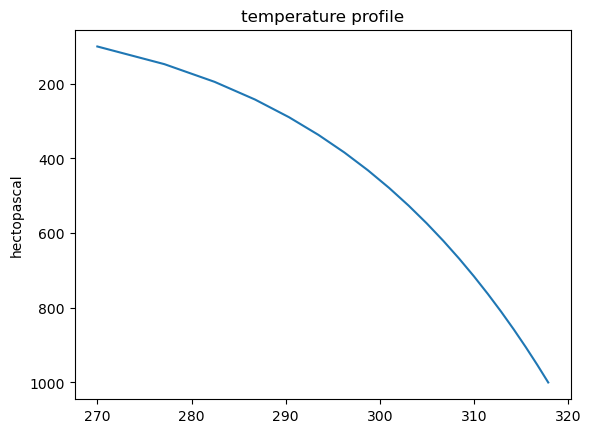

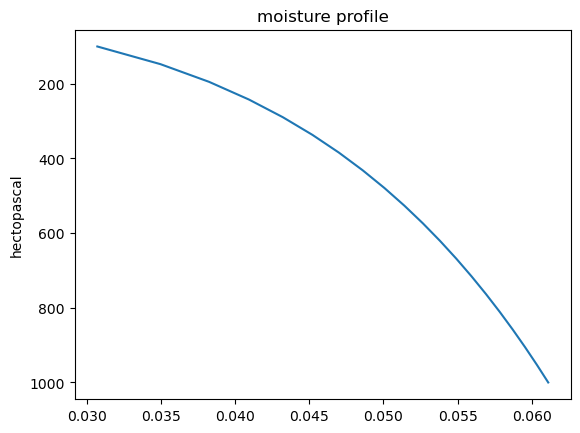

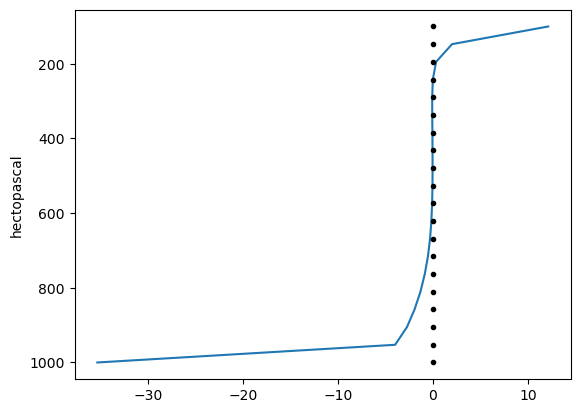

In [117]:
plt.figure()
plt.plot(T_profile,p)
plt.gca().invert_yaxis()
plt.title('temperature profile')
plt.figure()
plt.plot(q_profile,p)
plt.gca().invert_yaxis()
plt.title('moisture profile')
plt.figure()
plt.plot(LW_ref,p)
plt.gca().invert_yaxis()
plt.plot(LW_ref*0,p,'k.')